In [15]:
import os
import numpy as np
from dataclasses import dataclass

import torch
import torch.nn as nn

from datasets import load_from_disk
from transformers import (
    AutoModel,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    set_seed,
)
from scipy.stats import spearmanr

# 1. Dataset 로드

In [16]:
DATASET_PATH = "./empathy_dataset/hf_tokenized_roberta-base"

ds = load_from_disk(DATASET_PATH)
print(ds)
print(ds["train"][0])

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'emotion_labels'],
        num_rows: 5076
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'emotion_labels'],
        num_rows: 627
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'emotion_labels'],
        num_rows: 669
    })
})
{'input_ids': [0, 7164, 1000, 35, 38, 1299, 2181, 77, 38, 21, 1428, 184, 65, 363, 8, 10, 621, 1381, 7, 3598, 88, 127, 6625, 6, 8, 399, 75, 192, 162, 4, 38, 11006, 10916, 8, 51, 3514, 13539, 124, 88, 49, 6625, 6, 9597, 15, 49, 17690, 6, 8, 478, 5, 514, 37407, 4, 646, 3388, 510, 742, 8976, 59, 158, 107, 536, 38, 56, 10, 28242, 676, 4, 85, 21, 727, 207, 49, 7684, 53, 51, 478, 5, 514, 6745, 8, 5601, 4, 252, 56, 117, 1746, 53, 51, 818, 2075, 162, 160, 5, 921, 4, 646, 3388, 510, 742, 248, 4186, 35, 6553, 47, 6297, 143, 1746, 116, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [17]:
# torch 텐서 포맷 맞춰주기
for split in ds.keys():
    ds[split].set_format(
        type="torch",
        columns=["input_ids", "attention_mask", "labels", "emotion_labels"],
    )

emotion_labels_tensor = ds["train"]["emotion_labels"][:]

# 추출한 텐서에 torch.max() 적용
num_emotions = int(torch.max(emotion_labels_tensor).item() + 1)
print("num_emotions:", num_emotions)

num_emotions: 32


# 2. Baseline 멀티테스크 모델 정의

- 공유 인코더: AutoModel.from_pretrained(MODEL_NAME)

- 헤드 1 (회귀): 공감 점수 final_hybrid 예측

- 헤드 2 (분류): emotion_labels 예측

- logits에는 [reg_score, emo_logits...]를 붙여서 반환 → compute_metrics에서 둘 다 계산 가능하게 설계

In [18]:
MODEL_NAME = "roberta-base"  # 또는 "klue/roberta-base" (토크나이즈할 때 썼던 모델 이름으로 맞추기)

class EmpathyBaselineMultiTask(nn.Module):
    def __init__(self, model_name: str, num_emotions: int, lambda_emo: float = 0.3):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden_size = self.encoder.config.hidden_size

        self.dropout = nn.Dropout(0.1)

        # 공감 회귀 헤드 (H -> H -> 1)
        self.reg_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, 1),
        )

        # 감정 분류 헤드 (H -> num_emotions)
        self.emo_head = nn.Linear(hidden_size, num_emotions)

        self.loss_reg = nn.SmoothL1Loss()
        self.loss_ce = nn.CrossEntropyLoss()
        self.lambda_emo = lambda_emo

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        labels=None,          # float 공감 점수
        emotion_labels=None,  # long 감정 ID
    ):
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        # CLS 토큰 (roberta는 첫 토큰)
        cls = outputs.last_hidden_state[:, 0]  # [B, H]
        x = self.dropout(cls)

        # 회귀 / 분류
        reg_score = self.reg_head(x).squeeze(-1)    # [B]
        emo_logits = self.emo_head(x)               # [B, C]

        loss = None
        loss_reg = None
        loss_emo = None

        if labels is not None:
            loss_reg = self.loss_reg(reg_score, labels)

        if emotion_labels is not None:
            loss_emo = self.loss_ce(emo_logits, emotion_labels)

        if loss_reg is not None and loss_emo is not None:
            loss = loss_reg + self.lambda_emo * loss_emo
        elif loss_reg is not None:
            loss = loss_reg
        elif loss_emo is not None:
            loss = loss_emo

        # logits에 회귀 + 감정 로짓을 같이 넣어둠
        # [B, 1 + num_emotions]
        combined_logits = torch.cat(
            [reg_score.unsqueeze(-1), emo_logits],
            dim=-1
        )

        return {
            "loss": loss,
            "logits": combined_logits,
            "regression_logits": reg_score,
            "emotion_logits": emo_logits,
        }

In [19]:
set_seed(43)

model = EmpathyBaselineMultiTask(
    model_name=MODEL_NAME,
    num_emotions=num_emotions,
    lambda_emo=0.3,
)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 3. 메트릭 함수 정의(MAE, Spearman, Emotion Accuracy)

In [20]:
def compute_metrics(eval_pred):
    """
    eval_pred.predictions: np.ndarray, shape (N, 1 + num_emotions)
    eval_pred.label_ids:   dict 또는 np.ndarray (환경에 따라 다를 수 있음)
    """
    preds, labels = eval_pred

    if isinstance(preds, tuple):
        preds = preds[0]
    
    # preds: [N, 1 + C]
    reg_preds = preds[:, 0]          # 회귀 예측
    emo_logits = preds[:, 1:]        # [N, C]
    emo_pred = emo_logits.argmax(axis=-1)

    # label_ids가 dict / tuple / array 중 뭐로 오는지에 따라 처리
    if isinstance(labels, dict):
        reg_labels = labels["labels"]
        emo_labels = labels["emotion_labels"]
    elif isinstance(labels, (list, tuple)):
        # (labels, emotion_labels) 형태일 경우
        reg_labels = labels[0]
        emo_labels = labels[1]
    else:
        # 단일 array로 온다면, 여기서는 regression만 있는 경우로 가정
        reg_labels = labels
        emo_labels = None

    reg_labels = np.array(reg_labels).reshape(-1)

    mae = float(np.mean(np.abs(reg_preds - reg_labels)))
    spearman = float(spearmanr(reg_preds, reg_labels).correlation)

    metrics = {
        "mae": mae,
        "spearman": spearman,
    }

    if emo_labels is not None:
        emo_labels = np.array(emo_labels).reshape(-1)
        emo_acc = float((emo_pred == emo_labels).mean())
        metrics["emotion_accuracy"] = emo_acc

    return metrics


# 4. TrainingArgument & Trainer 설정

- label_names=["labels", "emotion_labels"]로 두 개의 라벨 모두 loss에 쓰이도록 지정

- metric_for_best_model="mae", greater_is_better=False로 MAE 최소화 기준으로 best checkpoint 선택

In [21]:
output_dir = "./empathy_roberta_baseline"

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="mae",
    greater_is_better=False,
    logging_steps=100,
    gradient_accumulation_steps=2,
    fp16=torch.cuda.is_available(),   # Colab GPU면 True
    warmup_ratio=0.06,
    report_to="none",                 # wandb 등 안 쓸 경우
    label_names=["labels", "emotion_labels"],
)


In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    tokenizer=None,          # 이미 토크나이즈된 상태라 필요 없음
    compute_metrics=compute_metrics,
)

C:\Users\yunhs\AppData\Local\Temp\ipykernel_4328\2895748070.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# 5. 학습 & 평가

In [23]:
train_result = trainer.train()
trainer.save_model(os.path.join(output_dir, "best_model"))

print("== Train result ==")
print(train_result)

print("== Best checkpoint ==", trainer.state.best_model_checkpoint)


Epoch,Training Loss,Validation Loss,Mae,Spearman,Emotion Accuracy
1,1.701100,1.435717,0.799597,0.140587,0.073365
2,1.265900,1.068498,0.450005,0.707591,0.186603
3,0.966600,0.860491,0.413234,0.755325,0.347687
4,0.599300,0.743478,0.369475,0.776680,0.424242
5,0.504700,0.715877,0.367600,0.775830,0.451356


== Train result ==
TrainOutput(global_step=795, training_loss=0.964905504910451, metrics={'train_runtime': 273.2414, 'train_samples_per_second': 92.885, 'train_steps_per_second': 2.91, 'total_flos': 0.0, 'train_loss': 0.964905504910451, 'epoch': 5.0})
== Best checkpoint == ./empathy_roberta_baseline\checkpoint-795


test set 평가

In [24]:
metrics_test = trainer.evaluate(ds["test"])
print("== Test metrics ==")
for k, v in metrics_test.items():
    print(f"{k}: {v:.4f}")

== Test metrics ==
eval_loss: 0.7503
eval_mae: 0.4020
eval_spearman: 0.7415
eval_emotion_accuracy: 0.4111
eval_runtime: 1.0108
eval_samples_per_second: 661.8550
eval_steps_per_second: 20.7760
epoch: 5.0000


# Loss / Accuracy 그래프 그리기

In [25]:
import pandas as pd

log_history = trainer.state.log_history
df_logs = pd.DataFrame(log_history)
df_logs.head()

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_mae,eval_spearman,eval_emotion_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.7011,8.531631,0.000028,0.628931,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,1.000000,159,1.435717,0.799597,0.140587,0.073365,1.3539,463.107,14.772,NaN,NaN,NaN,NaN,NaN
2,1.4234,3.020287,0.000024,1.257862,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.2659,8.057544,0.000020,1.886792,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,2.000000,318,1.068498,0.450005,0.707591,0.186603,0.7967,787.023,25.104,NaN,NaN,NaN,NaN,NaN


In [26]:
# Train step 로그만 (loss 있는 행)
df_train = df_logs[df_logs["loss"].notna()].copy()

# Eval 로그만 (eval_loss 있는 행)
df_eval = df_logs[df_logs["eval_loss"].notna()].copy()

df_train.head(), df_eval.head()

(     loss  grad_norm  learning_rate     epoch  step  eval_loss  eval_mae  \
 0  1.7011   8.531631       0.000028  0.628931   100        NaN       NaN   
 2  1.4234   3.020287       0.000024  1.257862   200        NaN       NaN   
 3  1.2659   8.057544       0.000020  1.886792   300        NaN       NaN   
 5  0.9666   8.207474       0.000016  2.515723   400        NaN       NaN   
 7  0.7826   6.852897       0.000012  3.144654   500        NaN       NaN   
 
    eval_spearman  eval_emotion_accuracy  eval_runtime  \
 0            NaN                    NaN           NaN   
 2            NaN                    NaN           NaN   
 3            NaN                    NaN           NaN   
 5            NaN                    NaN           NaN   
 7            NaN                    NaN           NaN   
 
    eval_samples_per_second  eval_steps_per_second  train_runtime  \
 0                      NaN                    NaN            NaN   
 2                      NaN                    N

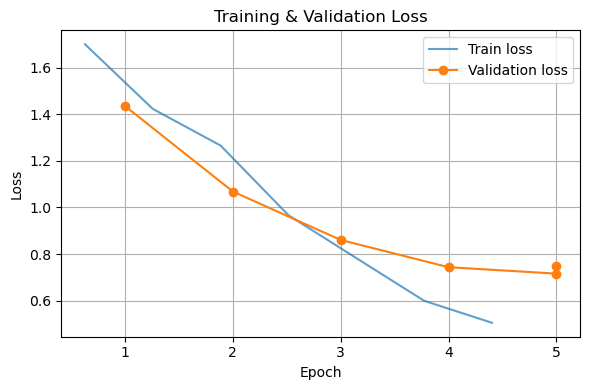

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

# Train loss: step마다 찍힌 값이라 epoch 기준으로 묶어서 평균 내도 되고,
# 그냥 epoch-별 대표점으로만 찍어도 됨.
plt.plot(df_train["epoch"], df_train["loss"], label="Train loss", alpha=0.7)

# Validation loss: epoch마다 한 번씩 찍히는 경우가 많음
plt.plot(df_eval["epoch"], df_eval["eval_loss"], label="Validation loss", marker="o")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("loss_curve_empathy_baseline.png", dpi=300, bbox_inches="tight")
plt.show()


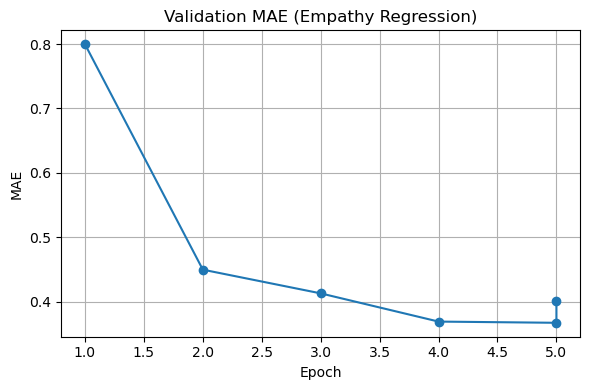

In [28]:
plt.figure(figsize=(6, 4))

plt.plot(df_eval["epoch"], df_eval["eval_mae"], marker="o")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Validation MAE (Empathy Regression)")
plt.grid(True)

plt.tight_layout()
plt.savefig("val_mae_empathy_baseline.png", dpi=300, bbox_inches="tight")
plt.show()
